In [117]:
import os
import sys
from pathlib import Path

# setting proper working directory
PROJECT_DIRECTORY = Path(os.path.abspath('')).resolve().parents[0]
sys.path.extend([str(PROJECT_DIRECTORY)])

print(f'Python {sys.version} on {sys.platform}')
print('Project directory: ', PROJECT_DIRECTORY)

Python 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)] on win32
Project directory:  C:\Users\s8347434\Documents\RecBole-GNN


In [118]:
# Define custom colors
tu_dd_blue = (0 / 255, 48 / 255, 93 / 255)
bu_green1 = (138 / 255, 203 / 255, 193 / 255)
bu_green2 = (0 / 255, 172 / 255, 169 / 255)
bu_green3 = (0 / 255, 131 / 255, 141 / 255)
ing_blue1 = (132 / 255, 207 / 255, 237 / 255)
ing_blue2 = (0 / 255, 161 / 255, 217 / 255)
ing_blue3 = (0 / 255, 119 / 255, 174 / 255)
ing_blue4 = (0 / 255, 105 / 255, 180 / 255)

In [119]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [203]:
user_topologies_df = pd.read_csv("../eval/log/Dataset/user_topological_characteristics2.csv", sep="\t")
new_column_name = {'best_users_to_community': 'best_user_to_community'}
user_topologies_df = user_topologies_df.rename(columns=new_column_name)
user_topologies_df = user_topologies_df.reset_index(drop=True)

In [204]:
als_df = pd.read_csv("log/Benchmark/old/ALS-Benchmark-RO.csv", sep="\t")
asym_user_df = pd.read_csv("log/Benchmark/RO/AsymKNNUser-Benchmark-RO.csv", sep="\t")

In [205]:
overall_df = pd.concat([als_df, asym_user_df], ignore_index=True)
overall_df['dataset'] = overall_df['dataset'].str.extract(r'-(\d+)$').astype(int)

In [206]:
# Function to process columns
def process_user_columns(df):
    for col in df.columns:
        if col.startswith('best_user_') or col.startswith('worst_user_') or col.startswith('clustering_coefficients'):
            # Apply transformation for each row in the selected columns
            df[col] = df[col].apply(ast.literal_eval)            
    return df

In [207]:
overall_df = process_user_columns(overall_df)
user_topologies_df = process_user_columns(user_topologies_df)

In [208]:
print(overall_df.head(2)['best_user_precision@[10]'])
print(user_topologies_df.head(2)['best_user_to_community'])

0    [{'364': '1.0'}, {'16': '1.0'}, {'929': '1.0'}...
1    [{'830': '1.0'}, {'81': '1.0'}, {'4': '1.0'}, ...
Name: best_user_precision@[10], dtype: object
0    {1: 1, 520: 2, 16: 2, 530: 2, 24: 2, 536: 2, 5...
1    {1: 1, 4: 1, 523: 2, 1042: 2, 530: 5, 539: 2, ...
Name: best_user_to_community, dtype: object


In [233]:
def match_topological_chars(data, topological_data):    
    df = data.copy()    

    # Initialize the new columns with empty or None values
    df['best_user_to_community'] = pd.NA
    df['worst_user_to_community'] = pd.NA
    df['best_user_communities'] = pd.NA
    df['worst_user_communities'] = pd.NA
    df['best_user_cluster_coefficients'] = pd.NA
    df['worst_user_cluster_coefficients'] = pd.NA
    df['degree_assort_best_users'] = pd.NA
    df['degree_assort_worst_users'] = pd.NA
    df['average_clustering_coef_dot_best_users'] = pd.NA
    df['average_clustering_coef_dot_worst_users'] = pd.NA

    for i in tqdm(topological_data['dataset'].unique(), total=topological_data['dataset'].nunique(), unit='datasets'):   
        for model in df['Model'].unique():
            
            # Filter the rows for the specific model and dataset
            matching_rows = df[(df['Model'] == model) & (df['dataset'] == i)]
            
            if matching_rows.empty:
                continue  # Skip if no matching rows are found for this model and dataset

            # Extract unique user IDs from best_user_ and worst_user_ columns
            best_user_ids = []
            worst_user_ids = []
            for col in matching_rows.columns:
                if col.startswith('best_user_') and col.endswith('[10]'):
                    for entry in matching_rows[col].values[0]:  # Assuming each entry is a list of dictionaries
                        best_user_ids.append(int(list(entry.keys())[0]))  # Add user ID to the set
                if col.startswith('worst_user_') and col.endswith('[10]'):
                    for entry in matching_rows[col].values[0]:  # Assuming each entry is a list of dictionaries
                        worst_user_ids.append(int(list(entry.keys())[0]))  # Add user ID to the set

            # Retrieve the topological data mapping
            best_user_to_community_map = topological_data[topological_data['dataset'] == i]['best_user_to_community'].values[0]            
            best_user_to_community_dict = {userId: best_user_to_community_map[userId] for userId in best_user_ids}
            best_user_to_community_list = [best_user_to_community_map[userId] for userId in best_user_ids]
            
            best_user_cluster_coefficients_map = topological_data[topological_data['dataset'] == i]['clustering_coefficients_best_users'].values[0]
            best_user_cluster_coefficients = [best_user_cluster_coefficients_map[userId] for userId in best_user_ids]
            
            worst_user_to_community_map = topological_data[topological_data['dataset'] == i]['worst_user_to_community'].values[0]            
            worst_user_to_community_dict = {userId: worst_user_to_community_map[userId] for userId in worst_user_ids}
            worst_user_to_community_list = [worst_user_to_community_map[userId] for userId in worst_user_ids]
            
            worst_user_cluster_coefficients_map = topological_data[topological_data['dataset'] == i]['clustering_coefficients_worst_users'].values[0]
            worst_user_cluster_coefficients = [worst_user_cluster_coefficients_map[userId] for userId in worst_user_ids]
            
            # Now we will assign the dictionary to each row individually
            for index, row in matching_rows.iterrows():
                # Set the dictionary in the specific row for 'best_user_to_community' and 'worst_user_to_community'
                df.at[index, 'best_user_to_community'] = best_user_to_community_dict
                df.at[index, 'worst_user_to_community'] = worst_user_to_community_dict
                df.at[index, 'best_user_communities'] = best_user_to_community_list
                df.at[index, 'worst_user_communities'] = worst_user_to_community_list
                df.at[index, 'best_user_cluster_coefficients'] = best_user_cluster_coefficients
                df.at[index, 'worst_user_cluster_coefficients'] = worst_user_cluster_coefficients
                df.at[index, 'degree_assort_best_users'] = topological_data[topological_data['dataset'] == i]['degree_assort_best_users'].values[0]
                df.at[index, 'degree_assort_worst_users'] = topological_data[topological_data['dataset'] == i]['degree_assort_worst_users'].values[0]
                df.at[index, 'average_clustering_coef_dot_best_users'] = topological_data[topological_data['dataset'] == i]['average_clustering_coef_dot_best_users'].values[0]
                df.at[index, 'average_clustering_coef_dot_worst_users'] = topological_data[topological_data['dataset'] == i]['average_clustering_coef_dot_worst_users'].values[0]                
                
    return df

In [234]:
matched_df = match_topological_chars(overall_df, user_topologies_df)

100%|██████████| 175/175 [00:02<00:00, 74.86datasets/s]


In [235]:
# NOTE: takes approx. 2-3 min
file_path = "log/Dataset/user_classical_characteristics.csv"

popularity_df = pd.read_csv(file_path, sep='\t')
popularity_df = process_user_columns(popularity_df)

merged_df = pd.merge(matched_df, popularity_df, on=['Model','dataset'], how='left')  # you can change how to 'left', 'right', or 'outer'
merged_df = merged_df[merged_df['dataset'] != 177]

In [236]:
merged_df = merged_df.dropna().reset_index(drop=True)

In [242]:
def plot_cluster_centroids(data, model, characteristic, num_datasets):    
   
    # Filter the data for the selected model
    df = data[data['Model'] == model].copy()
    
    best_cluster_centroids = []
    worst_cluster_centroids = []
    
    # Extract cluster centroids
    for index, row in tqdm(df.iloc[:num_datasets].iterrows(), total=num_datasets, unit='rows'):
        if characteristic == 'communities':
            ylabel = 'Average Community Value'
            best_cluster_centroids.append(np.mean(row['best_user_communities']))
            worst_cluster_centroids.append(np.mean(row['worst_user_communities']))
        elif characteristic == 'coefficients':
            ylabel = 'AvgClustC'
            best_cluster_centroids.append(np.mean(row['best_user_cluster_coefficients']))
            worst_cluster_centroids.append(np.mean(row['worst_user_cluster_coefficients']))
        elif characteristic == 'degree_assort':
            ylabel = 'Assort'
            best_cluster_centroids.append(row['degree_assort_best_users'])
            worst_cluster_centroids.append(row['degree_assort_worst_users'])
        elif characteristic == 'average_coefficients':
            ylabel = 'AvgClustC'
            best_cluster_centroids.append(row['average_clustering_coef_dot_best_users'])
            worst_cluster_centroids.append(row['average_clustering_coef_dot_worst_users'])

    # Set global font size and padding
    plt.rc('font', size=12)            
    plt.rc('axes', titlesize=30, labelsize=30)
    plt.rc('axes', labelpad=10) 
    plt.rc('xtick', labelsize=26)
    plt.rc('ytick', labelsize=26) 
    
    # Create a DataFrame for centroids
    df_centroids = pd.DataFrame({
        'Centroid': np.concatenate([best_cluster_centroids, worst_cluster_centroids]),
        'Group': ['Best Users'] * len(best_cluster_centroids) + ['Worst Users'] * len(worst_cluster_centroids)
    })
    
    custom_palette = [tu_dd_blue, bu_green1]
    
    # Plot centroids as a boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_centroids, x='Group', y='Centroid', palette=custom_palette, hue='Group')
    sns.stripplot(data=df_centroids, x='Group', y='Centroid', color=bu_green3, alpha=0.6, jitter=True)
    
    # Add labels and title
    #plt.xlabel("Group")
    plt.ylabel(ylabel)
    plt.show()

100%|██████████| 176/176 [00:00<00:00, 5868.44rows/s]


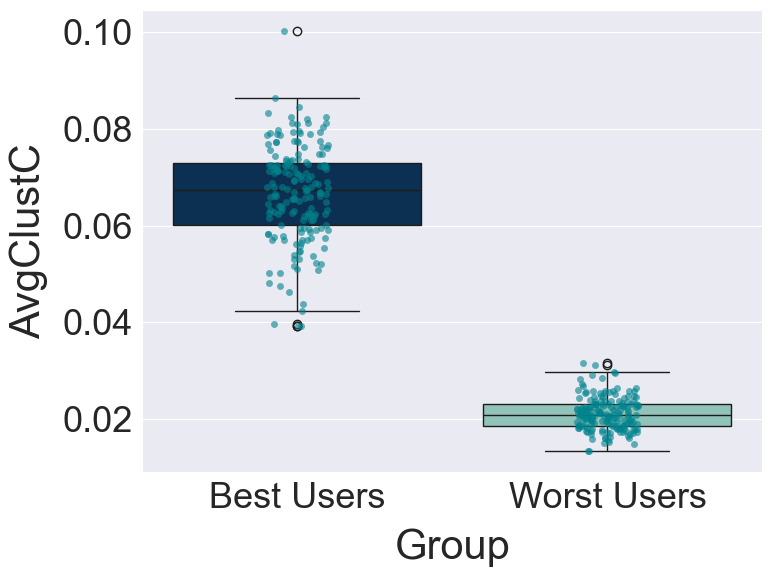

In [243]:
characteristics = ['communities', 'coefficients', 'degree_assort', 'average_coefficients']
model = "ALS"
plot_cluster_centroids(matched_df, model=model, characteristic=characteristics[1], num_datasets=matched_df[matched_df['Model']==model].shape[0])